# Import Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
import dagshub
dagshub.init(repo_owner='sourav664', repo_name='swiggy-delivery-time-prediction', mlflow=True)


Accessing as sourav664

Initialized MLflow to track repo "sourav664/swiggy-delivery-time-prediction"

Repository sourav664/swiggy-delivery-time-prediction initialized!

In [3]:
import mlflow

In [4]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow")

In [5]:
# mlflow experiment

mlflow.set_experiment("Exp 2 - Model Selection")

2025/03/21 16:41:44 INFO mlflow.tracking.fluent: Experiment with name 'Exp 2 - Model Selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/4e26262c28e8439b9a692857f3d6832c', creation_time=1742555504600, experiment_id='1', last_update_time=1742555504600, lifecycle_stage='active', name='Exp 2 - Model Selection', tags={}>

In [6]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [7]:
# load the data

df = pd.read_csv('swiggy_cleaned.csv')

df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [8]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [9]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [10]:
# check for missing values

df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day         0
distance               3630
distance_type          3630
dtype: int64

In [11]:
# check for duplicates

df.duplicated().sum()

0

<Axes: >

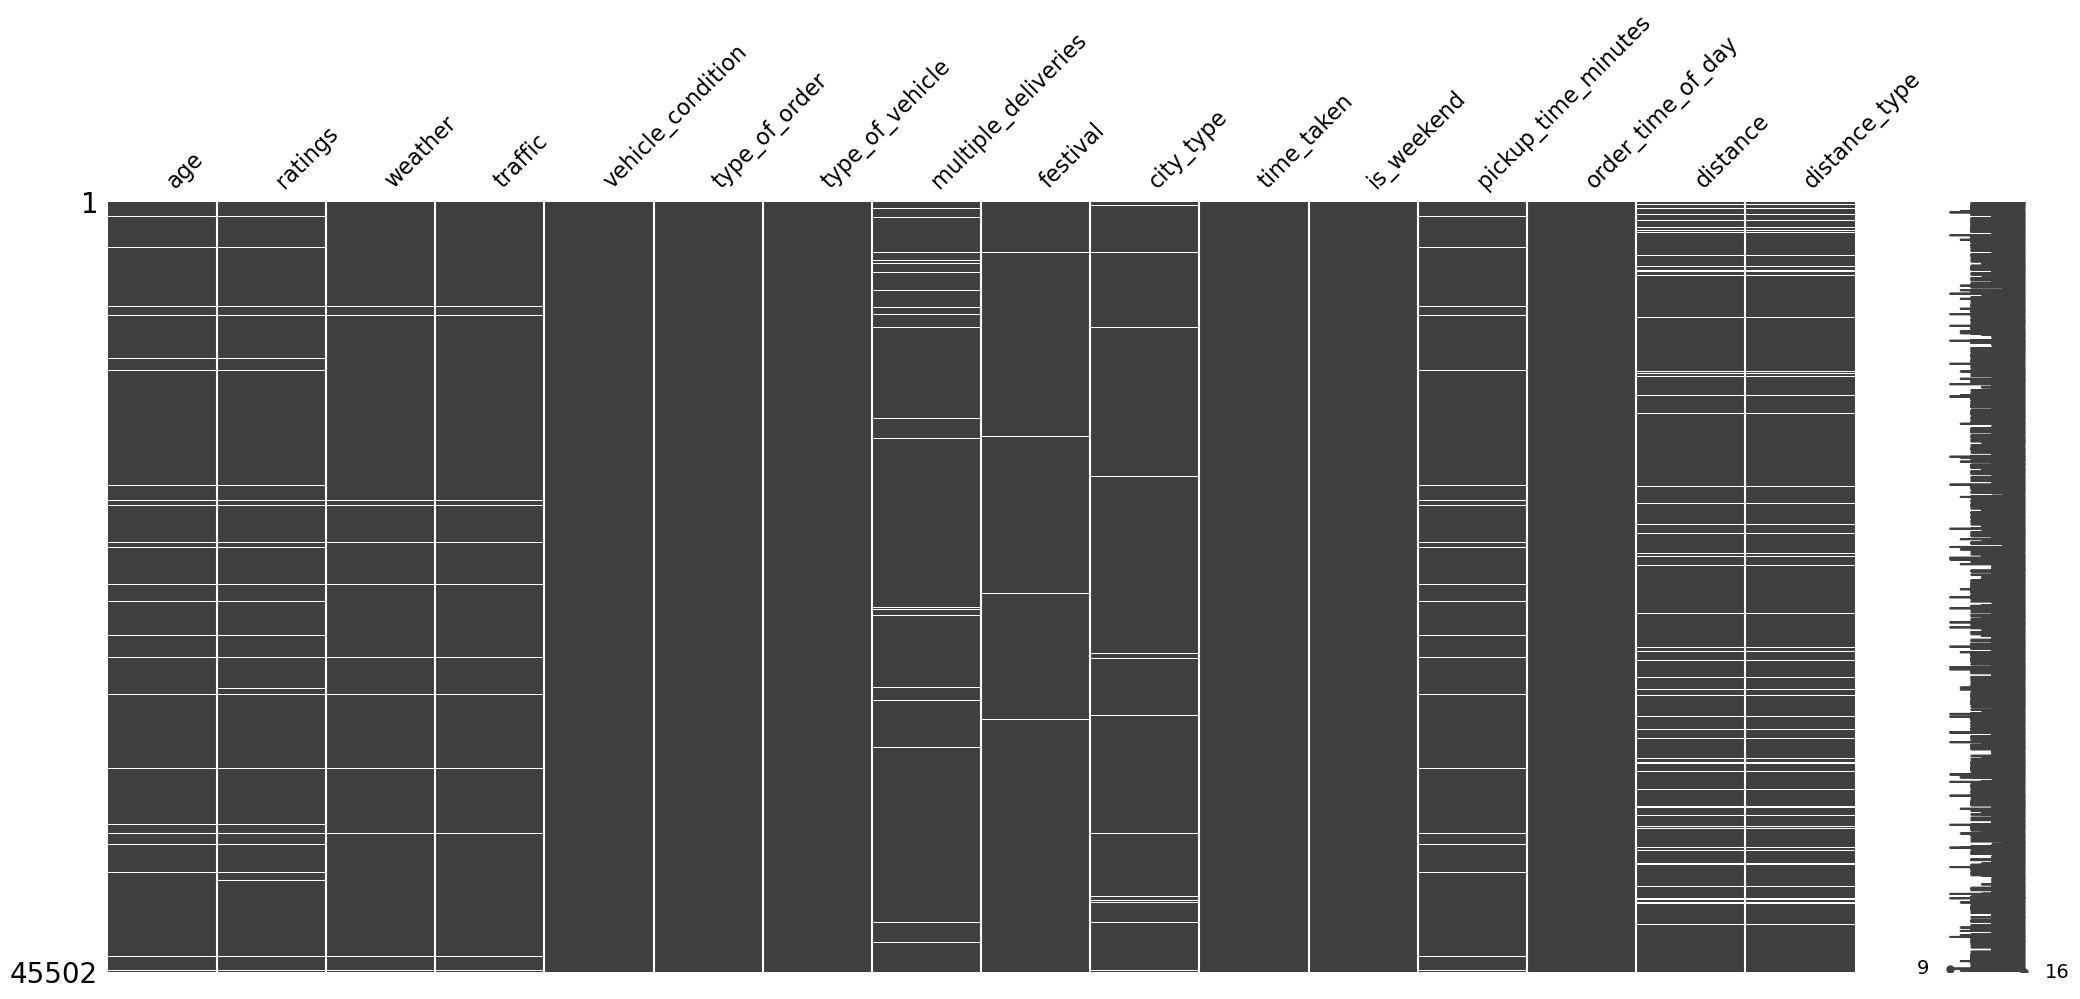

In [12]:
import missingno as msno

msno.matrix(df)

In [13]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'distance',
       'distance_type'],
      dtype='object')

# Drop Missing values

In [14]:
temp_df = df.copy().dropna()

In [15]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [16]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30451, 15)
The shape of test data is (7613, 15)


In [18]:
# missing values in train data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [19]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [20]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'distance',
       'distance_type'],
      dtype='object')

In [21]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


0.0

# Pre Processing Pipeline

In [22]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather',
                    'type_of_order',
                    'type_of_vehicle',
                    "festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [23]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [24]:
X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [ ]:
# # features to fill values with mode

# features_to_fill_mode = ['multiple_deliveries','festival','city_type']
# features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

# features_to_fill_missing

In [ ]:
# # simple imputer to fill categorical vars with mode

# simple_imputer = ColumnTransformer(transformers=[
#     ("mode_imputer",SimpleImputer(strategy="most_frequent",add_indicator=True),features_to_fill_mode),
#     ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing",add_indicator=True),features_to_fill_missing)
# ],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

# simple_imputer

In [ ]:
# simple_imputer.fit_transform(X_train)

In [ ]:
# simple_imputer.fit_transform(X_train).isna().sum()

In [ ]:
# knn imputer

# knn_imputer = KNNImputer(n_neighbors=5)

In [25]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [26]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [27]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'low' 'medium' 'high']
distance_type ['short' 'very_long' 'long' 'medium']


In [28]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [29]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                # ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor)
                                # ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scale', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

In [30]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

In [31]:
X_train_trans

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_urban,is_weekend_1,order_time_of_day_afternoon,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
24939,0.052632,0.80,0.5,0.163629,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1,0.0
9439,0.526316,0.96,1.0,0.157036,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2,1.0
18409,0.631579,1.00,0.0,0.160160,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,2,2.0
15267,0.789474,0.96,0.5,0.003145,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.0
43924,0.157895,0.88,0.5,0.084651,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20042,0.368421,0.88,1.0,0.621266,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2,1.0
7521,0.842105,0.88,0.0,0.788907,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,0,1.0
13483,0.736842,0.92,0.5,0.154044,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
1038,0.368421,0.92,0.5,0.992901,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2,1.0


In [ ]:
%pip install optuna

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error

In [34]:
def objective(trial):
    with mlflow.start_run(nested=True):
        model_name = trial.suggest_categorical("model",["SVM","RF","KNN","GB","XGB","LGBM"])

        if model_name == "SVM":
            kernel_svm = trial.suggest_categorical("kernel_svm",["linear","poly","rbf"])
            if kernel_svm == "linear":
                c_linear = trial.suggest_float("c_linear",0,10)
                model = SVR(C=c_linear,kernel="linear")

            elif kernel_svm == "poly":
                c_poly = trial.suggest_float("c_poly",0,10)
                degree_poly = trial.suggest_int("degree_poly",1,5)
                model = SVR(C=c_poly,degree=degree_poly,
                            kernel="poly")

            else:
                c_rbf = trial.suggest_float("c_rbf",0,100)
                gamma_rbf = trial.suggest_float("gamma_rbf",0,10)
                model = SVR(C=c_rbf,gamma=gamma_rbf,
                            kernel="rbf")

        elif model_name == "RF":
            n_estimators_rf = trial.suggest_int("n_estimators_rf",10,200)
            max_depth_rf = trial.suggest_int("max_depth_rf",2,20)
            model = RandomForestRegressor(n_estimators=n_estimators_rf,
                                        max_depth=max_depth_rf,
                                        random_state=42,
                                        n_jobs=-1)

        elif model_name == "GB":
            n_estimators_gb = trial.suggest_int("n_estimators_gb",10,200)
            learning_rate_gb = trial.suggest_float("learning_rate_gb",0,1)
            max_depth_gb = trial.suggest_int("max_depth_gb",2,20)
            model = GradientBoostingRegressor(n_estimators=n_estimators_gb,
                                                learning_rate=learning_rate_gb,
                                                max_depth=max_depth_gb,
                                                random_state=42)

        elif model_name == "KNN":
            n_neighbors_knn = trial.suggest_int("n_neighbors_knn",1,25)
            weights_knn = trial.suggest_categorical("weights_knn",["uniform","distance"])
            model = KNeighborsRegressor(n_neighbors=n_neighbors_knn,
                                        weights=weights_knn,n_jobs=-1)

        elif model_name == "XGB":
            n_estimators_xgb = trial.suggest_int("n_estimators_xgb",10,200)
            learning_rate_xgb = trial.suggest_float("learning_rate_xgb",0.1,0.5)
            max_depth_xgb = trial.suggest_int("max_depth_xgb",2,20)
            model = XGBRegressor(n_estimators=n_estimators_xgb,
                                    learning_rate=learning_rate_xgb,
                                    max_depth=max_depth_xgb,
                                    random_state=42,
                                    n_jobs=-1)

        elif model_name == "LGBM":
            n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm",10,200)
            learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm",0.1,0.5)
            max_depth_lgbm = trial.suggest_int("max_depth_lgbm",2,20)
            model = LGBMRegressor(n_estimators=n_estimators_lgbm,
                                    learning_rate=learning_rate_lgbm,
                                    max_depth=max_depth_lgbm,
                                    random_state=42)


        # train the model
        model.fit(X_train_trans,y_train_pt.values.ravel())

        # log model params
        mlflow.log_params(model.get_params())

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)

        # get the actual predictions values
        y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
        y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

        # calculate the error
        error = mean_absolute_error(y_test,y_pred_test_org)

        # log model_name
        mlflow.log_param("model",model_name)

        # log error
        mlflow.log_metric("MAE",error)

        return error

In [35]:
# create optuna study
study = optuna.create_study(direction="minimize",study_name="model_selection")

with mlflow.start_run(run_name="Best Model") as parent:
    # optimize the objective function
    study.optimize(objective,n_trials=30,n_jobs=-1)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score",study.best_value)

[I 2025-03-21 16:47:54,805] A new study created in memory with name: model_selection


🏃 View run unique-bird-160 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/a85549a9bdcc439dad2b6137f4855e39
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:06,357] Trial 0 finished with value: 4.314618875818571 and parameters: {'model': 'KNN', 'n_neighbors_knn': 21, 'weights_knn': 'distance'}. Best is trial 0 with value: 4.314618875818571.


🏃 View run dapper-dolphin-712 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/5c82ab616b6a4134a70126975f7b9f00
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:10,515] Trial 1 finished with value: 3.100002225392994 and parameters: {'model': 'RF', 'n_estimators_rf': 103, 'max_depth_rf': 16}. Best is trial 1 with value: 3.100002225392994.


🏃 View run resilient-bass-88 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/434863c59c124ccd836abec71c87dec5
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1
🏃 View run youthful-lark-174 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/c7d3e8684f154e1d89957d761bd7e4c1
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:19,498] Trial 3 finished with value: 4.349450868118368 and parameters: {'model': 'KNN', 'n_neighbors_knn': 11, 'weights_knn': 'uniform'}. Best is trial 1 with value: 3.100002225392994.
[I 2025-03-21 16:48:20,504] Trial 6 finished with value: 4.4102676491290005 and parameters: {'model': 'KNN', 'n_neighbors_knn': 5, 'weights_knn': 'distance'}. Best is trial 1 with value: 3.100002225392994.


🏃 View run amusing-koi-979 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/65842882b26940a49eb29e8a9a87944e
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1
🏃 View run skittish-yak-328 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/3b5dc61e0c344c28a740d85a1a79d955
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1
🏃 View run industrious-croc-622 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/8dd748800d464ffab63aee238803dc0c
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:36,497] Trial 5 finished with value: 3.070899959976105 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 106, 'learning_rate_lgbm': 0.14569236287415266, 'max_depth_lgbm': 10}. Best is trial 5 with value: 3.070899959976105.
[I 2025-03-21 16:48:38,552] Trial 7 finished with value: 3.0774184016330803 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 161, 'learning_rate_lgbm': 0.10342160786383428, 'max_depth_lgbm': 10}. Best is trial 5 with value: 3.070899959976105.


🏃 View run valuable-duck-431 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/6fecab89b87e4196a5a8fec17b680f5a
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:40,508] Trial 2 finished with value: 3.341980821526068 and parameters: {'model': 'XGB', 'n_estimators_xgb': 109, 'learning_rate_xgb': 0.39777933118751607, 'max_depth_xgb': 17}. Best is trial 5 with value: 3.070899959976105.


🏃 View run whimsical-panda-571 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/14e9cf0026d54b2192f6b298ba7b6f64
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:45,526] Trial 9 finished with value: 3.109925087295712 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 129, 'learning_rate_lgbm': 0.21879703416877994, 'max_depth_lgbm': 9}. Best is trial 5 with value: 3.070899959976105.
[I 2025-03-21 16:48:48,578] Trial 4 finished with value: 3.6474193452844985 and parameters: {'model': 'GB', 'n_estimators_gb': 49, 'learning_rate_gb': 0.3481879107828132, 'max_depth_gb': 20}. Best is trial 5 with value: 3.070899959976105.


🏃 View run clumsy-cat-437 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/82921d2ec3454909bc460685dfc31aa6
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:52,510] Trial 11 finished with value: 4.365333771537043 and parameters: {'model': 'KNN', 'n_neighbors_knn': 8, 'weights_knn': 'uniform'}. Best is trial 5 with value: 3.070899959976105.


🏃 View run caring-cow-267 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/6f55b87d095f4509b1d97953b6b1415e
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:48:58,539] Trial 12 finished with value: 3.0904900896570253 and parameters: {'model': 'RF', 'n_estimators_rf': 194, 'max_depth_rf': 15}. Best is trial 5 with value: 3.070899959976105.


🏃 View run bright-grouse-216 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/fc4f8f027d4a466a82f80d80f756dc45
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:50:53,009] Trial 16 finished with value: 3.0930523261680616 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 71, 'learning_rate_lgbm': 0.10995096675198837, 'max_depth_lgbm': 12}. Best is trial 5 with value: 3.070899959976105.


🏃 View run abrasive-dove-954 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/e8623743fa114727a41c8fcbf5a921a1
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:51:03,079] Trial 8 finished with value: 4.725846109374858 and parameters: {'model': 'SVM', 'kernel_svm': 'poly', 'c_poly': 4.0914171232307215, 'degree_poly': 1}. Best is trial 5 with value: 3.070899959976105.


🏃 View run mercurial-squid-165 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/38f45e012c714dcdbd99226fb75f910b
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:52:09,548] Trial 15 finished with value: 3.121628892771731 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 170, 'learning_rate_lgbm': 0.3268690740109259, 'max_depth_lgbm': 18}. Best is trial 5 with value: 3.070899959976105.


🏃 View run painted-worm-271 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/bbfb09b7b1be4104ac02306bb4eacbe3
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:52:11,789] Trial 18 finished with value: 3.057125471906443 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 165, 'learning_rate_lgbm': 0.11551784458085505, 'max_depth_lgbm': 11}. Best is trial 18 with value: 3.057125471906443.


🏃 View run carefree-wasp-688 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/49fa2b8695484fca95a1ec261e9039bf
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:52:17,326] Trial 22 finished with value: 3.83269559570417 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 14, 'learning_rate_lgbm': 0.4522239947195206, 'max_depth_lgbm': 3}. Best is trial 18 with value: 3.057125471906443.


🏃 View run traveling-shrike-949 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/5c1c61e1ce3f44f38ac2806a71d33249
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:52:40,515] Trial 21 finished with value: 3.720712440294781 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 199, 'learning_rate_lgbm': 0.11739879760115364, 'max_depth_lgbm': 2}. Best is trial 18 with value: 3.057125471906443.


🏃 View run youthful-carp-326 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/7fc2734bc098453ba4737123a4075994
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:52:56,240] Trial 24 finished with value: 3.596339622499629 and parameters: {'model': 'GB', 'n_estimators_gb': 190, 'learning_rate_gb': 0.9571995787291403, 'max_depth_gb': 2}. Best is trial 18 with value: 3.057125471906443.


🏃 View run rambunctious-wolf-70 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/06bde02e843243328a6937d063540bc6
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:53:01,245] Trial 25 finished with value: 5.471700393494366 and parameters: {'model': 'XGB', 'n_estimators_xgb': 12, 'learning_rate_xgb': 0.11375914758040256, 'max_depth_xgb': 2}. Best is trial 18 with value: 3.057125471906443.


🏃 View run efficient-moose-695 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/eb4e7c9ec5c249b19fb79b94cf19603d
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:54:03,920] Trial 20 finished with value: 3.1048827172561584 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 180, 'learning_rate_lgbm': 0.10283142383755725, 'max_depth_lgbm': 6}. Best is trial 18 with value: 3.057125471906443.


🏃 View run stately-mouse-457 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/139e93c1a71a42e393aff7bf1f52b4c8
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 16:54:10,098] Trial 19 finished with value: 3.117837105115405 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 198, 'learning_rate_lgbm': 0.10736889157662746, 'max_depth_lgbm': 6}. Best is trial 18 with value: 3.057125471906443.


🏃 View run upset-kite-48 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/0c74d27027f34403936dc219088b4d14
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:02:08,339] Trial 26 finished with value: 4.725964758532641 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 1.1060161754238438}. Best is trial 18 with value: 3.057125471906443.


🏃 View run kindly-roo-328 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/29479fc9efc84095a1be0bef7d0bc31e
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:04:33,736] Trial 29 finished with value: 3.097893803461363 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 121, 'learning_rate_lgbm': 0.22185545041108212, 'max_depth_lgbm': 13}. Best is trial 18 with value: 3.057125471906443.


🏃 View run gifted-dove-883 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/4704f9d49e6849869b4dd9fd47207d9c
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:09:26,921] Trial 23 finished with value: 4.7259547747332915 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 4.383458449917563}. Best is trial 18 with value: 3.057125471906443.


🏃 View run suave-gnu-22 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/a33774bcc0b740a5bd9d6b82128b2fbe
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:12:46,496] Trial 17 finished with value: 4.725948999396995 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 6.166447259662452}. Best is trial 18 with value: 3.057125471906443.


🏃 View run omniscient-stag-952 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/6c7419f1bfd145369ecb9699ed8eb3db
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:15:38,940] Trial 10 finished with value: 4.725999914671243 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 8.18389273285305}. Best is trial 18 with value: 3.057125471906443.


🏃 View run thoughtful-pug-772 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/33823192358f4e8fb5f79dfadd5b3491
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:16:53,859] Trial 13 finished with value: 4.725940111942417 and parameters: {'model': 'SVM', 'kernel_svm': 'linear', 'c_linear': 8.430220759905247}. Best is trial 18 with value: 3.057125471906443.


🏃 View run luxuriant-skink-235 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/a21a444d207445508e14eb708d31425f
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:22:51,188] Trial 27 finished with value: 5.102373748719777 and parameters: {'model': 'SVM', 'kernel_svm': 'rbf', 'c_rbf': 21.84813094224757, 'gamma_rbf': 1.7058998372302159}. Best is trial 18 with value: 3.057125471906443.


🏃 View run delightful-carp-134 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/40315bb44e064f009c783833c4fd0d4e
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:25:18,419] Trial 28 finished with value: 4.887899714706806 and parameters: {'model': 'SVM', 'kernel_svm': 'rbf', 'c_rbf': 39.602460505253845, 'gamma_rbf': 1.3848195439466715}. Best is trial 18 with value: 3.057125471906443.


🏃 View run sedate-mouse-772 at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/dfa9dfa441b248d384e06c712d8c2214
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


[I 2025-03-21 17:33:33,307] Trial 14 finished with value: 3.729720725203183 and parameters: {'model': 'SVM', 'kernel_svm': 'poly', 'c_poly': 3.770695328577448, 'degree_poly': 4}. Best is trial 18 with value: 3.057125471906443.


🏃 View run Best Model at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1/runs/a75fc7d14f594b7297283db5bf7f5ecf
🧪 View experiment at: https://dagshub.com/sourav664/swiggy-delivery-time-prediction.mlflow/#/experiments/1


In [36]:
# best score

study.best_value

3.057125471906443

In [37]:
study.best_params

{'model': 'LGBM',
 'n_estimators_lgbm': 165,
 'learning_rate_lgbm': 0.11551784458085505,
 'max_depth_lgbm': 11}

In [38]:
lgbm_params = {
    "n_estimators": 165,
    "learning_rate": 0.11551784458085505,
    "max_depth": 11
}

In [39]:
# train the model on best parameters

lgbm = LGBMRegressor(**lgbm_params)

lgbm.fit(X_train_trans,y_train_pt.values.ravel())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 30451, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


LGBMRegressor(learning_rate=0.11551784458085505, max_depth=11, n_estimators=165)

In [40]:
# get the predictions
y_pred_train = lgbm.predict(X_train_trans)
y_pred_test = lgbm.predict(X_test_trans)

In [41]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [42]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 2.84 minutes
The test error is 3.06 minutes


In [43]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.86
The test r2 score is 0.84


In [44]:
# dataframe of results

study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_c_linear,params_c_poly,params_c_rbf,params_degree_poly,params_gamma_rbf,...,params_max_depth_rf,params_max_depth_xgb,params_model,params_n_estimators_gb,params_n_estimators_lgbm,params_n_estimators_rf,params_n_estimators_xgb,params_n_neighbors_knn,params_weights_knn,state
0,0,4.314619,2025-03-21 16:47:55.540386,2025-03-21 16:48:06.357236,0 days 00:00:10.816850,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,21.0,distance,COMPLETE
1,1,3.100002,2025-03-21 16:47:55.540386,2025-03-21 16:48:10.515469,0 days 00:00:14.975083,NaN,NaN,NaN,NaN,NaN,...,16.0,NaN,RF,NaN,NaN,103.0,NaN,NaN,NaN,COMPLETE
2,2,3.341981,2025-03-21 16:47:55.545989,2025-03-21 16:48:40.507775,0 days 00:00:44.961786,NaN,NaN,NaN,NaN,NaN,...,NaN,17.0,XGB,NaN,NaN,NaN,109.0,NaN,NaN,COMPLETE
3,3,4.349451,2025-03-21 16:47:55.545989,2025-03-21 16:48:19.498495,0 days 00:00:23.952506,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,11.0,uniform,COMPLETE
4,4,3.647419,2025-03-21 16:47:55.545989,2025-03-21 16:48:48.576615,0 days 00:00:53.030626,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,GB,49.0,NaN,NaN,NaN,NaN,NaN,COMPLETE
5,5,3.070900,2025-03-21 16:47:55.547997,2025-03-21 16:48:36.497999,0 days 00:00:40.950002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,106.0,NaN,NaN,NaN,NaN,COMPLETE
6,6,4.410268,2025-03-21 16:47:55.550020,2025-03-21 16:48:20.504107,0 days 00:00:24.954087,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,5.0,distance,COMPLETE
7,7,3.077418,2025-03-21 16:47:55.551785,2025-03-21 16:48:38.552368,0 days 00:00:43.000583,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,161.0,NaN,NaN,NaN,NaN,COMPLETE
8,8,4.725846,2025-03-21 16:48:06.361245,2025-03-21 16:51:03.078350,0 days 00:02:56.717105,NaN,4.091417,NaN,1.0,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
9,9,3.109925,2025-03-21 16:48:10.519015,2025-03-21 16:48:45.526758,0 days 00:00:35.007743,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,129.0,NaN,NaN,NaN,NaN,COMPLETE


In [45]:
# model frequency

study.trials_dataframe()['params_model'].value_counts()

params_model
LGBM    11
SVM      9
KNN      4
RF       2
XGB      2
GB       2
Name: count, dtype: int64

In [46]:
# avg scores for all tested models

study.trials_dataframe().groupby("params_model")['value'].mean().sort_values()

params_model
RF      3.095246
LGBM    3.218552
GB      3.621879
KNN     4.359918
XGB     4.406841
SVM     4.675072
Name: value, dtype: float64

In [47]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=lgbm,
                                    transformer=pt)

In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model,
                         X_train_trans,
                         y_train,
                         scoring="neg_mean_absolute_error",
                         cv=5,n_jobs=-1)

scores

array([-2.99107624, -3.05193986, -3.10122328, -3.06774387, -3.03725887])

In [49]:
# mean score

- scores.mean()

3.0498484235644714

In [50]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

In [51]:
# partial coord plot

optuna.visualization.plot_parallel_coordinate(study,params=["model"])